In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np

import mahotas as mh

from skimage import io
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local, threshold_adaptive
from skimage.filters import sobel

path_comm = "/media/ula/D/mikroskop/CA1/split_pages/MAX_CA1_glass_28_rat_1_hipp_left_skan_2019-08-05_page"

dapi_path = path_comm + "1.tif"
homer_path = path_comm + "2.tif"
arc_path = path_comm + "3.tif"

In [2]:
#constants



In [3]:
def get_frac_thresh(arr, frac):
    min_lum = np.min(arr)
    max_lum = np.max(arr)
    return min_lum + frac*(max_lum - min_lum)

In [4]:
class Nucleus(): 
    def __init__(self, nucelusProps, idno):
        self.nucelusProps = nucelusProps
        self.idno = idno
   

In [5]:
def ieg_segmentation(image_ts, footprint_size, thresh_down, thresh_up, thresh_range, sobel_g=False): 
    T_mean = image.mean()
    opened = opening(image_ts > T_mean, square(3))
    bw = closing(opened, square(3))

    thre = get_frac_thresh(image, 0.15)
    binary_local = image_ts > thre
    
    local_masked_global = np.ma.masked_array(data = binary_local, mask = ~bw, fill_value = 0).filled()

    elev_map = sobel(mh.gaussian_filter(image_ts,2))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]

   
    labels = watershed(-elev_map, markers, mask=local_masked_global)

    label_image = label(labels, connectivity = 1)
    

    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(label_image)
    ax[0].set_title("Labelled")
    
    ax[1].imshow(image_ts)
    ax[1].set_title("orig img")

    areas = np.array([])
    regions_to_reconsider = []

    for region in regionprops(label_image):
        areas = np.append(areas, region.area)

   
    nuclei = np.array([])

    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Circle((region.centroid[1], region.centroid[0]), region.major_axis_length, 
                               fill=False, edgecolor='red', linewidth=2)
        if region.area >= thresh_up:
            ax[0].add_patch(rect)
            regions_to_reconsider = np.append(regions_to_reconsider, region)
        elif region.area >= thresh_down:
            nuclei = np.append(nuclei, region)    
            ax[0].add_patch(rect)

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    return nuclei, regions_to_reconsider, label_image

In [6]:
def dapi_segmentation(image_ts, footprint_size, thresh_down, thresh_up, thresh_range, sobel_g=False): 
    T_mean = image.mean()
    opened = opening(image_ts > T_mean, square(5))
    bw = closing(opened, square(5))

    local_thresh = threshold_local(image_ts, thresh_range, offset=0)
    binary_local = image_ts > local_thresh

    
    local_masked_global = np.ma.masked_array(data = binary_local, mask = ~bw, fill_value = 0).filled()

    elev_map = sobel(mh.gaussian_filter(image_ts,1))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]
   
    labels = watershed(-elev_map, markers, mask=local_masked_global)

    label_image = label(labels, connectivity = 2)
    

    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(label_image)
    ax[0].set_title("Labelled")
    
    ax[1].imshow(image_ts)
    ax[1].set_title("orig img")

    areas = np.array([])
    regions_to_reconsider = []

    for region in regionprops(label_image):
        areas = np.append(areas, region.area)

    std = np.std(areas)
    mean = np.mean(areas)


    nuclei = np.array([])

    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)

        if region.area >= thresh_up:
            ax[0].add_patch(rect)
            regions_to_reconsider = np.append(regions_to_reconsider, region)
        elif region.area >= thresh_down:
            new_nucleus = Nucleus(region,len(nuclei))
            nuclei = np.append(nuclei, new_nucleus)      
            ax[0].add_patch(rect)

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    return nuclei, regions_to_reconsider, label_image

In [7]:
image = io.imread(dapi_path)

nuclei, regions_to_reconsider, thresholded = dapi_segmentation(image, 16, 50, 450, 39)#, sobel_g = True)
    
arc_im = io.imread(arc_path)
homer_im = io.imread(homer_path)

arc_locations, _,_ = ieg_segmentation(arc_im, 2, 7, 30, 21)
homer_locations, _,_ = ieg_segmentation(homer_im, 2, 7, 30, 21)

/home/ula/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2416: UserWarning: invalid ImageJ metadata or corrupted file
  warnings.warn("invalid ImageJ metadata or corrupted file")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/home/ula/anaconda3/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ula/anaconda3/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


<IPython.core.display.Javascript object>

In [10]:
def prepare_coords_set(coords_tab):
    return set(tuple([m, n]) for m, n in zip(coords_tab[:,0], coords_tab[:,1]))

def find_ieg_colloc(ieg_locs, nuclei, to_reevaluate):
    ieg_positive = np.array([])
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(thresholded)
    for nucleus in nuclei:
        ieg_no = 0
        for ieg_dot in ieg_locs:
            nucleus_coords_set = prepare_coords_set(nucleus.nucelusProps.coords)
            ieg_coords_set = prepare_coords_set(ieg_dot.coords)      
            #if the centroid of area identified as immediate early gene presence is inside of nucleus, add it
            #to the number of ieg collocalized with the nucleus
            len_pre = len(nucleus_coords_set)
            
            set_pre = nucleus_coords_set.copy()
            #print(ieg_coords_set)
            nucleus_coords_set.add((int(np.floor(ieg_dot.centroid[0])), int(np.floor(ieg_dot.centroid[1]))))
            len_post = len(nucleus_coords_set)
            #print(nucleus_coords_set.difference(set_pre))
            
            if (len_pre == len_post):
                ieg_no +=1
                if ieg_no == 1:
                    ieg_positive = np.append(ieg_positive, nucleus.idno)

                    minr, minc, maxr, maxc = nucleus.nucelusProps.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                                      fill=False, edgecolor='green', linewidth=1)
                    ax.add_patch(rect)     
                    minr, minc, maxr, maxc = ieg_dot.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                                      fill=False, edgecolor='red', linewidth=1)
                

                    ax.add_patch(rect)   
        if ieg_no > 1:
            to_reevaluate = np.append(to_reevaluate, nucleus)
            
    ax.set_axis_off()

    fig.tight_layout()
    plt.title("colloc")
    plt.show()
    return ieg_positive, to_reevaluate

<IPython.core.display.Javascript object>


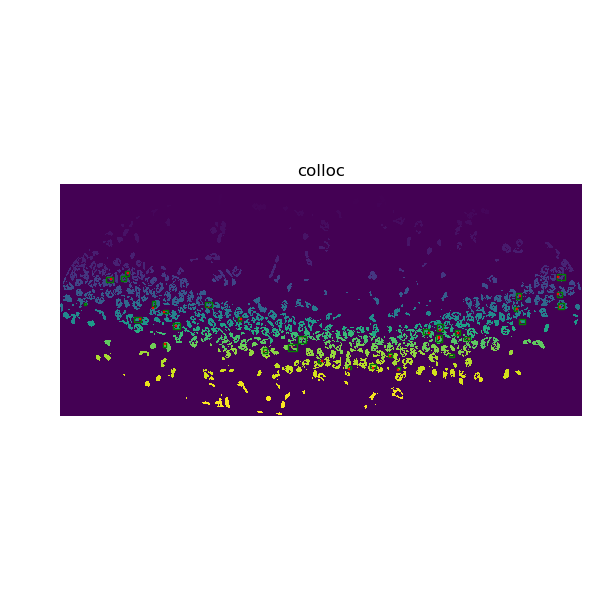

<IPython.core.display.Javascript object>


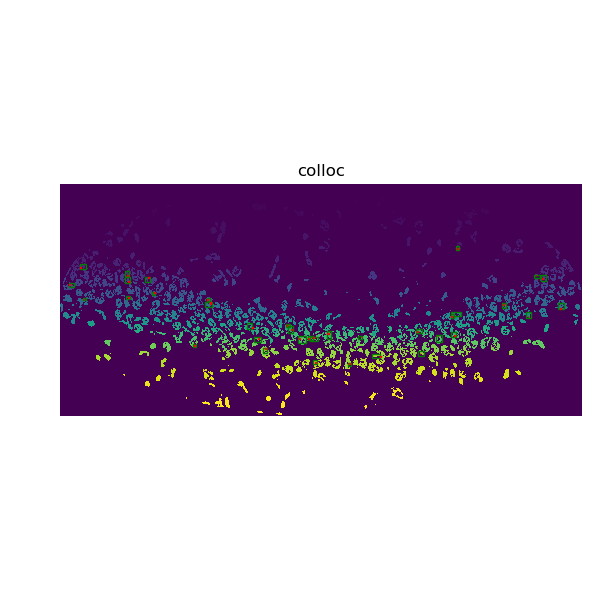

arc len  31 4
homer len  36 6


In [11]:
to_reevalueate = []

arc_pos, arc_mult =  find_ieg_colloc(arc_locations, nuclei, to_reevalueate)
homer_pos, homer_mult =  find_ieg_colloc(homer_locations, nuclei, to_reevalueate)

print('arc len ', len(arc_pos), len(arc_mult))
print('homer len ', len(homer_pos),len(homer_mult))


In [12]:
print(arc_pos)
print(homer_pos)

[ 64.  71.  82.  85. 131. 138. 169. 172. 177. 178. 201. 213. 241. 244.
 255. 278. 282. 311. 318. 348. 351. 358. 385. 389. 403. 417. 418. 430.
 439. 442. 443.]
[ 27.  45.  64.  75.  77.  87.  88. 110. 130. 148. 154. 155. 172. 177.
 182. 222. 223. 231. 279. 285. 290. 310. 331. 336. 348. 350. 351. 352.
 356. 359. 388. 403. 409. 419. 431. 435.]


In [13]:
np.intersect1d(arc_pos, homer_pos)

array([ 64., 172., 177., 348., 351., 403.])

<IPython.core.display.Javascript object>


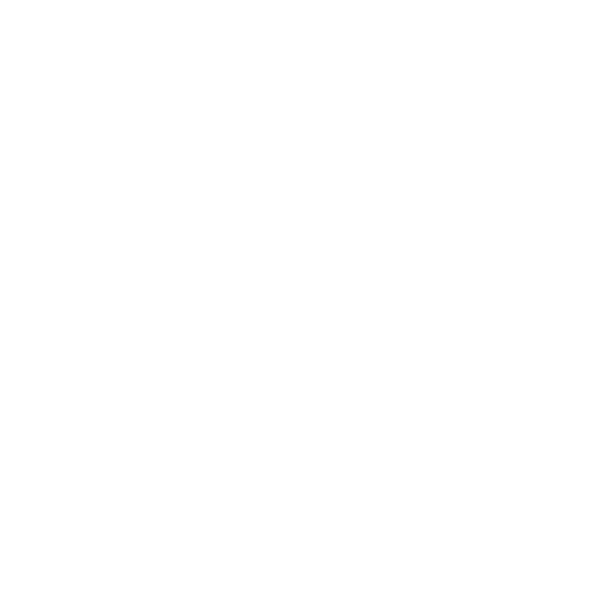

In [22]:
full_color_path = "/media/ula/D/mikroskop/CA1/MAX_CA1_glass_28_rat_1_hipp_left_skan_2019-08-05.tif"

full_color_im = io.imread(full_color_path)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(full_color_im)
ax.set_axis_off()

fig.tight_layout()
plt.show()